In [200]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric
import string
from pathlib import Path
from transformers import (
    AdamW,
    Adafactor,
    T5ForConditionalGeneration,
    T5Tokenizer,
    T5Config,
    get_linear_schedule_with_warmup
)
from torch.utils.data import RandomSampler

[nltk_data] Downloading package punkt to /home/priya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
## Login to WandB and get your API Key
!wandb login

In [201]:
import wandb
YOUR_KEY = ''
os.environ["WANDB_API_KEY"] = YOUR_KEY
wandb_logger = WandbLogger(project='closedbook-triviaqa')
# wandb.init(project="transformers_tutorials_summarization")

## Load Data using NLP Library

In [202]:
from nlp import list_datasets
datasets_list = list_datasets()
print(', '.join(dataset.id for dataset in datasets_list))

aeslc, ag_news, ai2_arc, allocine, anli, arcd, art, billsum, biomrc, blended_skill_talk, blimp, blog_authorship_corpus, bookcorpus, boolq, break_data, c4, cfq, civil_comments, clue, cmrc2018, cnn_dailymail, coarse_discourse, com_qa, common_gen, commonsense_qa, compguesswhat, conll2000, conll2003, coqa, cornell_movie_dialog, cos_e, cosmos_qa, crd3, crime_and_punish, csv, daily_dialog, definite_pronoun_resolution, discofuse, docred, doqa, drop, eli5, emo, emotion, empathetic_dialogues, eraser_multi_rc, esnli, event2Mind, fever, flores, fquad, gap, germeval_14, gigaword, glue, guardian_authorship, hans, hansards, hellaswag, hyperpartisan_news_detection, imdb, iwslt2017, jeopardy, json, kilt_tasks, kilt_wikipedia, kor_nli, lc_quad, librispeech_lm, lince, lm1b, math_dataset, math_qa, matinf, mlqa, mlsum, movie_rationales, ms_marco, multi_news, multi_nli, multi_nli_mismatch, mwsc, natural_questions, newsgroup, newsroom, openbookqa, openwebtext, opinosis, pandas, para_crawl, pg19, piaf, polyg

### Select Trivia QA data set
See more about it at - https://www.tensorflow.org/datasets/catalog/trivia_qa

In [203]:
from nlp import load_dataset
dataset = load_dataset('trivia_qa', 'unfiltered.nocontext')

In [204]:
print(dataset.keys())

dict_keys(['train', 'validation', 'test'])


In [205]:
print("Size of train dataset: ", dataset['train'].shape)

Size of train dataset:  (87622, 6)


In [206]:
print("Size of Validation dataset: ", dataset['validation'].shape)

Size of Validation dataset:  (11313, 6)


We can use the test data set for validation

In [207]:
print("Size of ca test dataset: ", dataset['test'].shape)

Size of ca test dataset:  (10832, 6)


### Look at Examples in this data set

In [208]:
print(dataset['train'][0].keys())

dict_keys(['answer', 'entity_pages', 'question', 'question_id', 'question_source', 'search_results'])


In [209]:
print(" Example of Question: ", dataset['train'][6]['question'])

 Example of Question:  From which country did Angola achieve independence in 1975?


In [210]:
print(" Example of Answer: ", dataset['train'][6]['answer'])

 Example of Answer:  {'aliases': ['Portogało', 'Republic of Portugal', 'PORTUGAL', 'Portekiz', 'Portugallu', 'O Papagaio', 'ISO 3166-1:PT', 'Portunga', 'Phu-to-ga', 'Potigal', 'Portûnga', 'Portugul', 'An Phortaingéil', 'Portugāle', 'Portugale', 'Portingale', 'Potiti', 'Portugali', 'Portugall', 'Portekîz', 'Bo Dao Nha', 'Portuguese Republic', 'Portogallo', 'Portugaul', 'Portogalo', 'Portyngal', 'Yn Phortiugal', 'Portugalio', 'Portugál', 'Portugual', 'Portuga', 'Portgual', 'Portugalsko', 'Portugaleje', 'Phû-tô-gâ', 'Portugalujo', 'Portugalija', 'Pertual', 'Pòtigal', 'Portugal', 'Bồ Đào Nha', 'Portugalska', 'República Portuguesa', 'Portiwgal', 'Portugalėjė', 'Portúgal', 'Portegal', 'An Phortaingeil', 'Republica Portuguesa'], 'matched_wiki_entity_name': '', 'normalized_aliases': ['portûnga', 'portugalujo', 'portogalo', 'portiwgal', 'portugalio', 'portugalija', 'república portuguesa', 'portugāle', 'portugalėjė', 'portugaleje', 'portgual', 'potigal', 'portugallu', 'portogało', 'phortaingéil'

In [211]:
print(" Example of Search Results: ", dataset['train'][6]['search_results'])

 Example of Search Results:  {'description': [], 'filename': [], 'rank': [], 'search_context': [], 'title': [], 'url': []}


### Inputs for T5 Model
Since this is a closed book question answering problem, we will take as input the question and fine tune the model to output the answer

### Estimate average length of Question and Answer

In [212]:
tiny_dataset = dataset['train'].select(list(range(0, 100)))
ques_len = []
ans_len=[]

In [213]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['question']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    ques_len.append(len(text_words))
    summary_example = example['answer']['value']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    ans_len.append(len(summary_words))

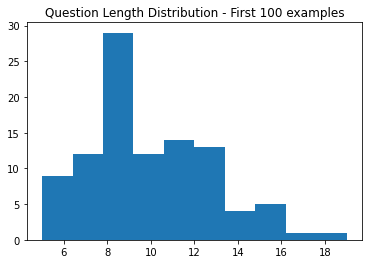

In [214]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ques_len)
plt.title('Question Length Distribution - First 100 examples')
plt.show()

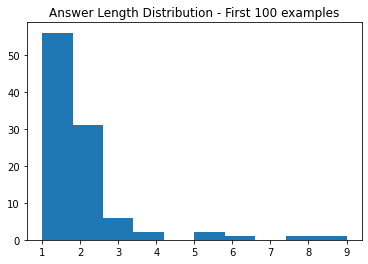

In [215]:
plt.hist(ans_len)
plt.title('Answer Length Distribution - First 100 examples')
plt.show()

In [216]:
print("Average Length of text: ", sum(ques_len)/len(ques_len))

Average Length of text:  9.88


In [217]:
print("Average Length of Summary: ", sum(ans_len)/len(ans_len))

Average Length of Summary:  1.77


## Define Model

In [218]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [219]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [220]:
def exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def approx_match_score(prediction, ground_truth):
    answer = normalize_answer(prediction) 
    gt = normalize_answer(ground_truth)
    match = 0
    gt_words = gt.split(" ")
    for word in gt_words:
        if word in answer:
            match = 1
            return match
    return match

In [221]:
def calculate_scores(predictions, ground_truths):
    em_score = 0
    subset_match_score = 0
    
    for i in range(len(predictions)):
        ground_truth = ground_truths[i]
        prediction = predictions[i]
        em_score +=  exact_match_score(prediction, ground_truth)
        subset_match_score += approx_match_score(prediction, ground_truth)
    
    em_score /= len(predictions)
    subset_match_score /= len(predictions)
    return em_score*100, subset_match_score*100
    

In [222]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams
#         self.config = T5Config(hparams.model_name_or_path,dropout_rate=0.2)
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
#         self.model.dropout_rate=0.2
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
        
        self.step_count = 0
        self.output_dir = Path(self.hparams.output_dir)
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        self.em_score_list = []
        self.subset_score_list =[]
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=10,
            num_beams=2,
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        targets = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=targets)
        em_score, subset_match_score = calculate_scores(preds, targets)
        
        self.em_score_list.append(em_score)
        self.subset_score_list.append(subset_match_score)
        
        em_score = torch.tensor(em_score,dtype=torch.float32)
        subset_match_score = torch.tensor(subset_match_score,dtype=torch.float32)
        
        base_metrics.update(em_score=em_score, subset_match_score=subset_match_score)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)

        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        if len(self.em_score_list) <= 2:
            average_em_score = sum(self.em_score_list) / len(self.em_score_list) 
            average_subset_match_score = sum(self.subset_score_list)/len(self.subset_score_list)
            
        else:
            latest_em_score = self.em_score_list[:-2]
            latest_subset_score = self.subset_score_list[:-2]
            average_em_score = sum(latest_em_score) / len(latest_em_score) 
            average_subset_match_score = sum(latest_subset_score)/len(latest_subset_score)
            
        
        
        average_em_score = torch.tensor(average_em_score,dtype=torch.float32)
        average_subset_match_score = torch.tensor(average_subset_match_score,dtype=torch.float32)
        tensorboard_logs.update(em_score=average_em_score, subset_match_score=average_subset_match_score)
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "em_score" : average_em_score,
                "subset_match_score" : average_subset_match_score,
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        
#         optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        optimizer = Adafactor(optimizer_grouped_parameters, lr=self.hparams.learning_rate, scale_parameter=False,
                             relative_step=False)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        sampler=RandomSampler(train_dataset)
        dataloader = DataLoader(train_dataset, sampler=sampler,  batch_size=self.hparams.train_batch_size, drop_last=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        t_total = 100000
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        sampler=RandomSampler(validation_dataset)
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, sampler =sampler, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def on_save_checkpoint(self, checkpoint):
        save_path = self.output_dir.joinpath("best_tfmr")
        self.model.config.save_step = self.step_count
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

In [223]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

## Define a DataSet class for the loader

In [224]:
class Trivia_QA_Closedbook(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('trivia_qa', 'unfiltered.nocontext', split=type_path)
        if num_samples:
            rand_indices = np.random.choice(self.dataset.shape[0], num_samples, replace=False)
            self.dataset = self.dataset.select(list(rand_indices))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['question']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['question'])  
        target_ = self.clean_text(example_batch['answer']['value'])  
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
  

### Test the dataset function

In [225]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = Trivia_QA_Closedbook(tokenizer, 'validation', None, 25, 10, True)
len(dataset)

11313

In [226]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

Input Text:  Kagoshima international airport is in which country?

Shape of Tokenized Text:  torch.Size([25])

Sanity check - Decode Text:  Kagoshima international airport is in which country?
Sanity check - Decode Summary:  Japan


## Define Arguments

In [227]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_input_length=25,
    max_output_length=10,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=1e-5,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=10,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.5, 
    n_val=5000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=101,
)

!mkdir -p t5_trivia_qa_closedbook

In [228]:
args_dict.update({'output_dir': 't5_trivia_qa_closedbook', 'num_train_epochs':150,
                 'train_batch_size': 48, 'eval_batch_size': 48, 'learning_rate': 1e-3,
                 'resume_from_checkpoint': 't5_trivia_qa_closedbook/checkpointepoch=53.ckpt'})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 't5_trivia_qa_closedbook', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_input_length': 25, 'max_output_length': 10, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 48, 'eval_batch_size': 48, 'num_train_epochs': 150, 'gradient_accumulation_steps': 10, 'n_gpu': 1, 'resume_from_checkpoint': 't5_trivia_qa_closedbook/checkpointepoch=53.ckpt', 'val_check_interval': 0.5, 'n_val': 5000, 'n_train': -1, 'n_test': -1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 101}


In [229]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="em_score", mode="max", save_top_k=1
)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    callbacks=[LoggingCallback()],
)

In [230]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return Trivia_QA_Closedbook(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

## Train Model

In [231]:
model = T5FineTuner(args)

In [232]:
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [233]:
trainer.fit(model)

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 


Saving latest checkpoint..


1

## Check Model Predictions on Trivia Test Set

In [234]:
import textwrap
from tqdm.auto import tqdm

In [235]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = Trivia_QA_Closedbook(tokenizer, 'validation', None, 25, 10, False)

In [236]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)

In [237]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 25])

In [238]:
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
            max_length=10,
            num_beams=2,
            early_stopping=True
        )

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [239]:
for i in range(10):
    lines = textwrap.wrap("Trivia Question:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Answer: %s" % targets[i])
    print("\nPredicted Answer from T5: %s" % dec[i])
    print("=====================================================================\n")

Trivia Question: US veterinary pathologist Daniel Salmon (1850-1914) oversaw the discovery of what,
named eponym

Actual Answer: Salmonella

Predicted Answer from T5: Undiscovered ancestor

Trivia Question: What are the traditional words used to vote in the British House of Lords?

Actual Answer: Content / Non content

Predicted Answer from T5: Turn of the clock

Trivia Question: Which American singer-songwriter wrote 'Sweet Baby James', the title track of his
second album in

Actual Answer: James Taylor

Predicted Answer from T5: JEFFREY ARCHER

Trivia Question: Released in 1962, which was the first of the 'Carry On....' films to be released in

Actual Answer: 'CARRY ON CRUIS

Predicted Answer from T5: 'CARRY ON SERGE

Trivia Question: In January 1968 who was chosen as leader of the Communist Party in Czechoslovakia?

Actual Answer: Alexander Dubcek

Predicted Answer from T5: Radovan Karadzic

Trivia Question: What was placed in Earth’s orbit by Discovery in 1990?

Actual Answer: Hubb

## Testing using AutoModel loader

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deep-learning-analytics/triviaqa-t5-base")

model = AutoModelWithLMHead.from_pretrained("deep-learning-analytics/triviaqa-t5-base")

In [288]:
text = "Mount Everest is found in which mountain range?"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
preprocess_text = text.strip().replace("\n","")
tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)
model = model.to(device)

outs = model.model.generate(
            tokenized_text,
            max_length=10,
            num_beams=2,
            early_stopping=True
           )

dec = [tokenizer.decode(ids) for ids in outs]
print("Predicted Answer: ", dec)

Predicted Answer:  ['Himalayas']
